 # Notebook 4: Keyword-Based Bias Features

 ## Purpose
 - Implement extended keyword dictionaries for 10 bias dimensions
 - Calculate keyword intensity scores (not just counts)
 - Detect co-occurrence patterns
 - Context-aware scoring (positive/negative context)
 - Calculate stereotype density

 ## Inputs
 - `data/processed/articles_with_events_sample_30000.csv`

 ## Outputs
 - `data/processed/keyword_features_sample_30000.parquet`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter, defaultdict
from itertools import combinations

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported")

Libraries imported


In [2]:
# Paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

INPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'
OUTPUT_FILE = PROCESSED_DIR / 'keyword_features.parquet'

 ## 1. Load Data

In [3]:
print("Loading data...")
df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df):,} articles")

# Use cleaned text if available, otherwise use original
text_column = 'article_text_cleaned' if 'article_text_cleaned' in df.columns else 'article_text'
df['text_for_analysis'] = df[text_column].fillna('')

Loading data...
Loaded 49,926 articles


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/4140847889.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


 ## 2. Extended Keyword Dictionaries (10 Bias Dimensions)

In [4]:
print("Defining keyword dictionaries...")

# Dictionary structure: {category: {subcategory: {keywords, weight}}}

BIAS_KEYWORDS = {
    'gender': {
        'male_terms': {
            'keywords': ['man', 'men', 'male', 'boy', 'gentleman', 'husband', 'father', 'brother', 'son',
                         'he', 'his', 'him', 'himself'],
            'weight': 1.0
        },
        'female_terms': {
            'keywords': ['woman', 'women', 'female', 'girl', 'lady', 'wife', 'mother', 'sister', 'daughter',
                         'she', 'her', 'hers', 'herself'],
            'weight': 1.0
        },
        'stereotypes': {
            'keywords': ['emotional', 'irrational', 'aggressive', 'bossy', 'hysterical', 'nurturing',
                         'submissive', 'housewife', 'career woman'],
            'weight': 2.0
        }
    },

    'religion': {
        'hindu': {
            'keywords': ['hindu', 'hinduism', 'temple', 'brahmin', 'puja', 'diwali', 'holi', 'vedas'],
            'weight': 1.0
        },
        'muslim': {
            'keywords': ['muslim', 'islam', 'mosque', 'quran', 'ramadan', 'eid', 'islamic', 'sharia'],
            'weight': 1.0
        },
        'christian': {
            'keywords': ['christian', 'christianity', 'church', 'bible', 'christmas', 'easter', 'pastor'],
            'weight': 1.0
        },
        'sikh': {
            'keywords': ['sikh', 'sikhism', 'gurdwara', 'guru', 'khalsa', 'turban'],
            'weight': 1.0
        },
        'religious_stereotypes': {
            'keywords': ['fundamentalist', 'extremist', 'radical', 'terrorist', 'communal', 'fanatic'],
            'weight': 2.5
        }
    },

    'caste': {
        'upper_caste': {
            'keywords': ['brahmin', 'kshatriya', 'upper caste', 'forward caste', 'general category'],
            'weight': 1.0
        },
        'lower_caste': {
            'keywords': ['dalit', 'scheduled caste', 'scheduled tribe', 'backward', 'obc', 'untouchable'],
            'weight': 1.0
        },
        'caste_stereotypes': {
            'keywords': ['casteist', 'caste discrimination', 'caste violence', 'atrocity', 'untouchability'],
            'weight': 2.0
        }
    },

    'region': {
        'north_india': {
            'keywords': ['delhi', 'punjab', 'haryana', 'up', 'uttar pradesh', 'rajasthan', 'north india'],
            'weight': 1.0
        },
        'south_india': {
            'keywords': ['tamil nadu', 'karnataka', 'kerala', 'andhra', 'telangana', 'south india'],
            'weight': 1.0
        },
        'east_india': {
            'keywords': ['bengal', 'west bengal', 'odisha', 'bihar', 'jharkhand', 'east india'],
            'weight': 1.0
        },
        'west_india': {
            'keywords': ['maharashtra', 'mumbai', 'gujarat', 'goa', 'west india'],
            'weight': 1.0
        },
        'regional_stereotypes': {
            'keywords': ['backward region', 'developed state', 'hindi belt', 'north-south divide'],
            'weight': 2.0
        }
    },

    'socioeconomic': {
        'wealthy': {
            'keywords': ['rich', 'wealthy', 'elite', 'affluent', 'upper class', 'privileged', 'luxury'],
            'weight': 1.0
        },
        'poor': {
            'keywords': ['poor', 'poverty', 'slum', 'underprivileged', 'lower class', 'deprived'],
            'weight': 1.0
        },
        'class_stereotypes': {
            'keywords': ['lazy poor', 'welfare', 'handout', 'entitled rich', 'inequality'],
            'weight': 2.0
        }
    },

    'political': {
        'left': {
            'keywords': ['left', 'liberal', 'congress', 'communist', 'socialist', 'progressive'],
            'weight': 1.0
        },
        'right': {
            'keywords': ['right', 'bjp', 'conservative', 'nationalist', 'hindutva'],
            'weight': 1.0
        },
        'political_stereotypes': {
            'keywords': ['anti-national', 'bhakt', 'libtard', 'propaganda', 'biased media'],
            'weight': 2.5
        }
    },

    'age': {
        'young': {
            'keywords': ['youth', 'young', 'millennial', 'teenager', 'adolescent', 'student'],
            'weight': 1.0
        },
        'old': {
            'keywords': ['elderly', 'senior', 'old', 'aged', 'geriatric', 'pensioner'],
            'weight': 1.0
        },
        'age_stereotypes': {
            'keywords': ['entitled millennial', 'lazy youth', 'out of touch', 'senile', 'tech illiterate'],
            'weight': 2.0
        }
    },

    'disability': {
        'physical': {
            'keywords': ['disabled', 'handicapped', 'wheelchair', 'paralyzed', 'crippled', 'differently abled'],
            'weight': 1.0
        },
        'mental': {
            'keywords': ['mental illness', 'depression', 'anxiety', 'psychiatric', 'mentally ill'],
            'weight': 1.0
        },
        'disability_stereotypes': {
            'keywords': ['suffer from', 'victim of', 'confined to wheelchair', 'burden', 'helpless'],
            'weight': 2.5
        }
    },

    'urban_rural': {
        'urban': {
            'keywords': ['city', 'urban', 'metropolitan', 'cosmopolitan', 'town'],
            'weight': 1.0
        },
        'rural': {
            'keywords': ['rural', 'village', 'countryside', 'agricultural', 'farming'],
            'weight': 1.0
        },
        'urban_rural_stereotypes': {
            'keywords': ['backward village', 'uneducated rural', 'sophisticated urban', 'rural poverty'],
            'weight': 2.0
        }
    },

    'language': {
        'hindi': {
            'keywords': ['hindi', 'hindi speaking', 'hindi imposition', 'rashtrabhasha'],
            'weight': 1.0
        },
        'english': {
            'keywords': ['english speaking', 'english medium', 'westernized'],
            'weight': 1.0
        },
        'regional_languages': {
            'keywords': ['tamil', 'telugu', 'bengali', 'marathi', 'gujarati', 'kannada', 'malayalam'],
            'weight': 1.0
        },
        'language_stereotypes': {
            'keywords': ['language chauvinism', 'linguistic minority', 'language barrier', 'vernacular'],
            'weight': 2.0
        }
    }
}

print(f"Defined keywords for {len(BIAS_KEYWORDS)} bias dimensions")
for dimension, categories in BIAS_KEYWORDS.items():
    total_keywords = sum(len(cat['keywords']) for cat in categories.values())
    print(f"  - {dimension}: {len(categories)} categories, {total_keywords} keywords")

Defining keyword dictionaries...
Defined keywords for 10 bias dimensions
  - gender: 3 categories, 35 keywords
  - religion: 5 categories, 35 keywords
  - caste: 3 categories, 16 keywords
  - region: 5 categories, 28 keywords
  - socioeconomic: 3 categories, 18 keywords
  - political: 3 categories, 16 keywords
  - age: 3 categories, 17 keywords
  - disability: 3 categories, 16 keywords
  - urban_rural: 3 categories, 14 keywords
  - language: 4 categories, 18 keywords


 ## 3. Keyword Matching Functions

In [5]:
def count_keywords_in_text(text, keyword_list):
    """Count occurrences of keywords in text"""
    if not text:
        return 0
    text_lower = text.lower()
    count = 0
    for keyword in keyword_list:
        # Use word boundaries to avoid partial matches
        pattern = r'\b' + re.escape(keyword) + r'\b'
        count += len(re.findall(pattern, text_lower))
    return count


def calculate_keyword_intensity(text, keyword_dict, text_length):
    """
    Calculate intensity score = (weighted_count / text_length) * 1000
    This normalizes for article length
    """
    if not text or text_length == 0:
        return 0.0

    weighted_count = 0
    for category, info in keyword_dict.items():
        keywords = info['keywords']
        weight = info['weight']
        count = count_keywords_in_text(text, keywords)
        weighted_count += count * weight

    # Normalize by text length (per 1000 words)
    intensity = (weighted_count / text_length) * 1000
    return round(intensity, 4)


print("Keyword matching functions defined")

Keyword matching functions defined


 ## 4. Calculate Keyword Features for All Dimensions

In [6]:
print("Calculating keyword features for all articles...")
print("This may take several minutes for large datasets...")

# Calculate word count for intensity normalization
df['word_count_for_intensity'] = df['text_for_analysis'].str.split().str.len().fillna(1)

# Store all features
keyword_features = {}

for dimension, categories in BIAS_KEYWORDS.items():
    print(f"\nProcessing {dimension} bias...")

    # Overall dimension count and intensity
    all_keywords_in_dimension = []
    for cat_info in categories.values():
        all_keywords_in_dimension.extend(cat_info['keywords'])

    df[f'{dimension}_keyword_count'] = df['text_for_analysis'].apply(
        lambda x: count_keywords_in_text(x, all_keywords_in_dimension)
    )

    df[f'{dimension}_intensity'] = df.apply(
        lambda row: calculate_keyword_intensity(
            row['text_for_analysis'],
            categories,
            row['word_count_for_intensity']
        ),
        axis=1
    )

    # Per-category counts
    for category, info in categories.items():
        col_name = f'{dimension}_{category}_count'
        df[col_name] = df['text_for_analysis'].apply(
            lambda x: count_keywords_in_text(x, info['keywords'])
        )
        keyword_features[col_name] = col_name

    # Bias indicator (1 if any keywords found)
    df[f'has_{dimension}_bias'] = (df[f'{dimension}_keyword_count'] > 0).astype(int)

    print(f"  {dimension}: {df[f'has_{dimension}_bias'].sum():,} articles with keywords")

print("\nAll keyword features calculated")

Calculating keyword features for all articles...
This may take several minutes for large datasets...

Processing gender bias...
  gender: 17,115 articles with keywords

Processing religion bias...
  religion: 6,141 articles with keywords

Processing caste bias...
  caste: 1,194 articles with keywords

Processing region bias...
  region: 14,133 articles with keywords

Processing socioeconomic bias...
  socioeconomic: 5,156 articles with keywords

Processing political bias...
  political: 18,533 articles with keywords

Processing age bias...
  age: 16,971 articles with keywords

Processing disability bias...
  disability: 1,336 articles with keywords

Processing urban_rural bias...
  urban_rural: 10,192 articles with keywords

Processing language bias...
  language: 2,630 articles with keywords

All keyword features calculated


 ## 5. Co-occurrence Analysis

In [7]:
print("\nCalculating keyword co-occurrence patterns...")

# Calculate co-occurrence between bias dimensions
dimensions = list(BIAS_KEYWORDS.keys())
cooccurrence_matrix = pd.DataFrame(0, index=dimensions, columns=dimensions)

for dim1, dim2 in combinations(dimensions, 2):
    cooccur_count = ((df[f'has_{dim1}_bias'] == 1) & (df[f'has_{dim2}_bias'] == 1)).sum()
    cooccurrence_matrix.loc[dim1, dim2] = cooccur_count
    cooccurrence_matrix.loc[dim2, dim1] = cooccur_count

# Fill diagonal
for dim in dimensions:
    cooccurrence_matrix.loc[dim, dim] = df[f'has_{dim}_bias'].sum()

print("Co-occurrence matrix calculated")


Calculating keyword co-occurrence patterns...
Co-occurrence matrix calculated


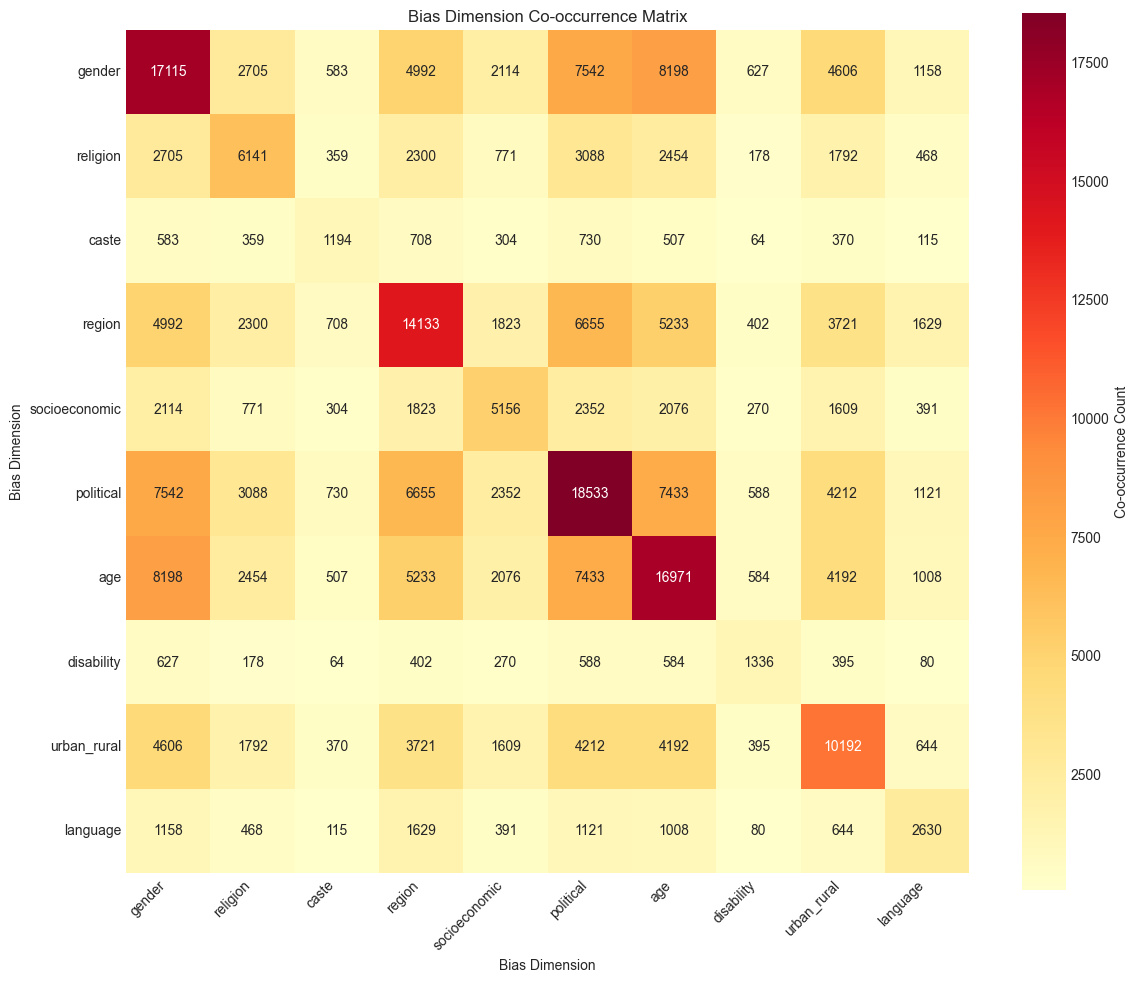

In [8]:
# Visualize co-occurrence
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix.astype(int), annot=True, fmt='d', cmap='YlOrRd',
            square=True, cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Bias Dimension Co-occurrence Matrix')
plt.xlabel('Bias Dimension')
plt.ylabel('Bias Dimension')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Key Insights: Bias Dimension Co-occurrence

1) Political, gender, age, and region biases dominate overall, as seen from the darkest diagonal cells (highest counts), indicating these are the most frequently tagged bias dimensions in the corpus.

2) Biases often intersect rather than appear in isolation, with strong co‑occurrences between pairs like gender–age, gender–political, age–political, and region–urban_rural, while dimensions such as disability and caste co‑occur much less frequently.

In [9]:
# Calculate co-occurrence rates for feature engineering
for dim1, dim2 in combinations(dimensions, 2):
    col_name = f'{dim1}_{dim2}_cooccurrence'
    df[col_name] = ((df[f'has_{dim1}_bias'] == 1) & (df[f'has_{dim2}_bias'] == 1)).astype(int)

print("Co-occurrence features created")

Co-occurrence features created


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/3238987620.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = ((df[f'has_{dim1}_bias'] == 1) & (df[f'has_{dim2}_bias'] == 1)).astype(int)
/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/3238987620.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = ((df[f'has_{dim1}_bias'] == 1) & (df[f'has_{dim2}_bias'] == 1)).astype(int)
/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/3238987620.py:4: PerformanceWar

 ## 6. Stereotype Density

In [10]:
print("\nCalculating stereotype density...")

# For each dimension, calculate stereotype keyword ratio
for dimension, categories in BIAS_KEYWORDS.items():
    # Find stereotype category
    stereotype_cats = [cat for cat in categories.keys() if 'stereotype' in cat]

    if stereotype_cats:
        stereotype_count = 0
        total_count = df[f'{dimension}_keyword_count']

        for cat in stereotype_cats:
            col = f'{dimension}_{cat}_count'
            if col in df.columns:
                stereotype_count += df[col]

        # Stereotype density = stereotype_count / total_count
        df[f'{dimension}_stereotype_density'] = np.where(
            total_count > 0,
            stereotype_count / total_count,
            0
        )
    else:
        df[f'{dimension}_stereotype_density'] = 0

print("Stereotype density calculated")


Calculating stereotype density...
Stereotype density calculated


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/1304508702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{dimension}_stereotype_density'] = np.where(
/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/1304508702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{dimension}_stereotype_density'] = np.where(
/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/1304508702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

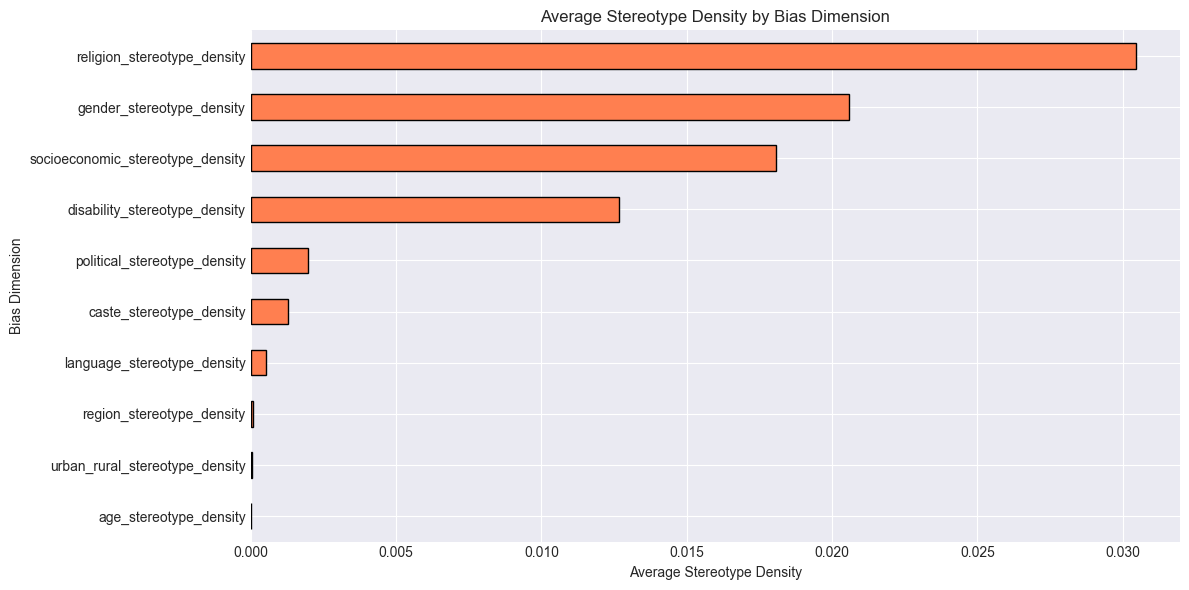

In [11]:
# Visualize stereotype density
stereotype_densities = [f'{dim}_stereotype_density' for dim in dimensions
                        if f'{dim}_stereotype_density' in df.columns]

if stereotype_densities:
    fig, ax = plt.subplots(figsize=(12, 6))
    df[stereotype_densities].mean().sort_values().plot(kind='barh', ax=ax, color='coral', edgecolor='black')
    ax.set_xlabel('Average Stereotype Density')
    ax.set_ylabel('Bias Dimension')
    ax.set_title('Average Stereotype Density by Bias Dimension')
    plt.tight_layout()
    plt.show()

#### Key Insights: Average Stereotype Density by Bias Dimension

1) Religion, gender, socioeconomic status, and disability show the highest stereotype density, meaning articles referencing these dimensions are most likely to contain stereotype-related language.

2) Political, caste, language, region, urban–rural, and age stereotypes appear at much lower densities, indicating they are referenced with stereotypical cues far less frequently in comparison.

 ## 7. Bias Distribution Analysis

In [12]:
print("\nAnalyzing bias distribution...")

# Overall bias statistics
bias_counts = {}
for dimension in dimensions:
    count = df[f'has_{dimension}_bias'].sum()
    percentage = (count / len(df)) * 100
    bias_counts[dimension] = {'count': count, 'percentage': percentage}

bias_df = pd.DataFrame(bias_counts).T
bias_df = bias_df.sort_values('count', ascending=False)

print("\nBias prevalence:")
print(bias_df)


Analyzing bias distribution...

Bias prevalence:
                 count  percentage
political      18533.0   37.120939
gender         17115.0   34.280735
age            16971.0   33.992309
region         14133.0   28.307896
urban_rural    10192.0   20.414213
religion        6141.0   12.300204
socioeconomic   5156.0   10.327284
language        2630.0    5.267796
disability      1336.0    2.675960
caste           1194.0    2.391539


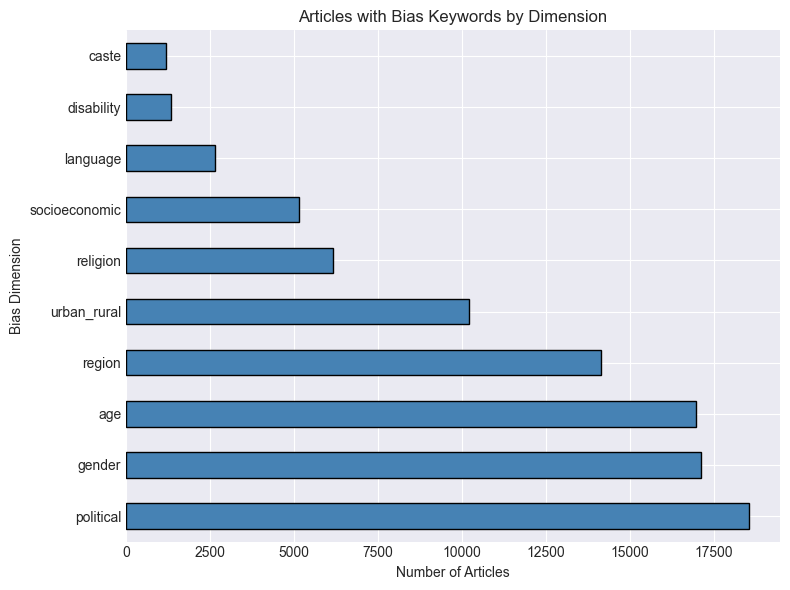

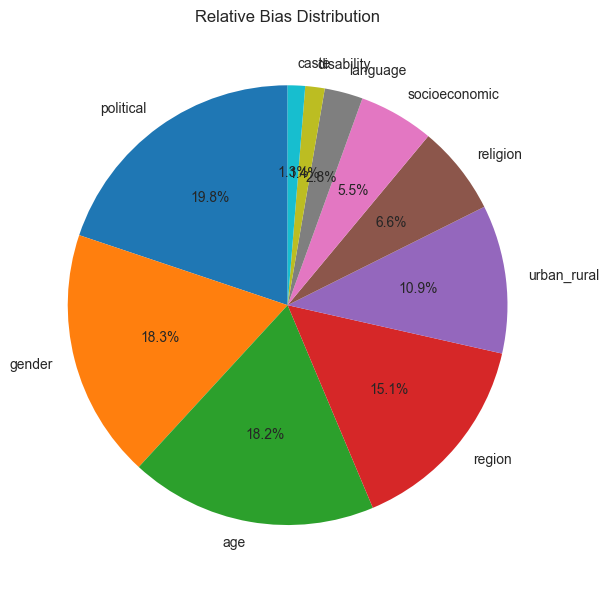

In [13]:
# Visualize bias prevalence

# Bar chart
plt.figure(figsize=(8, 6))
bias_df['count'].plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Number of Articles')
plt.ylabel('Bias Dimension')
plt.title('Articles with Bias Keywords by Dimension')
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(8, 6))
bias_df['percentage'].plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Relative Bias Distribution')
plt.tight_layout()
plt.show()

#### Key Insights: Articles with Bias Keywords by Dimension

1) Political, gender, and age biases appear in the largest number of articles, followed closely by regional bias, indicating these dimensions dominate bias‑related coverage.

2) Caste, disability, and language biases are referenced far less often, suggesting they are comparatively underrepresented in explicit bias‐keyword mentions.

 ## 8. Multi-dimensional Bias

In [14]:
print("\nAnalyzing multi-dimensional bias...")

# Count how many bias dimensions each article has
bias_dimension_cols = [f'has_{dim}_bias' for dim in dimensions]
df['bias_dimension_count'] = df[bias_dimension_cols].sum(axis=1)

# Distribution
print("\nMulti-dimensional bias distribution:")
print(df['bias_dimension_count'].value_counts().sort_index())


Analyzing multi-dimensional bias...

Multi-dimensional bias distribution:
bias_dimension_count
0      9179
1     13386
2     12285
3      8364
4      4289
5      1654
6       530
7       176
8        54
9         7
10        2
Name: count, dtype: int64


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_22309/2149466192.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bias_dimension_count'] = df[bias_dimension_cols].sum(axis=1)


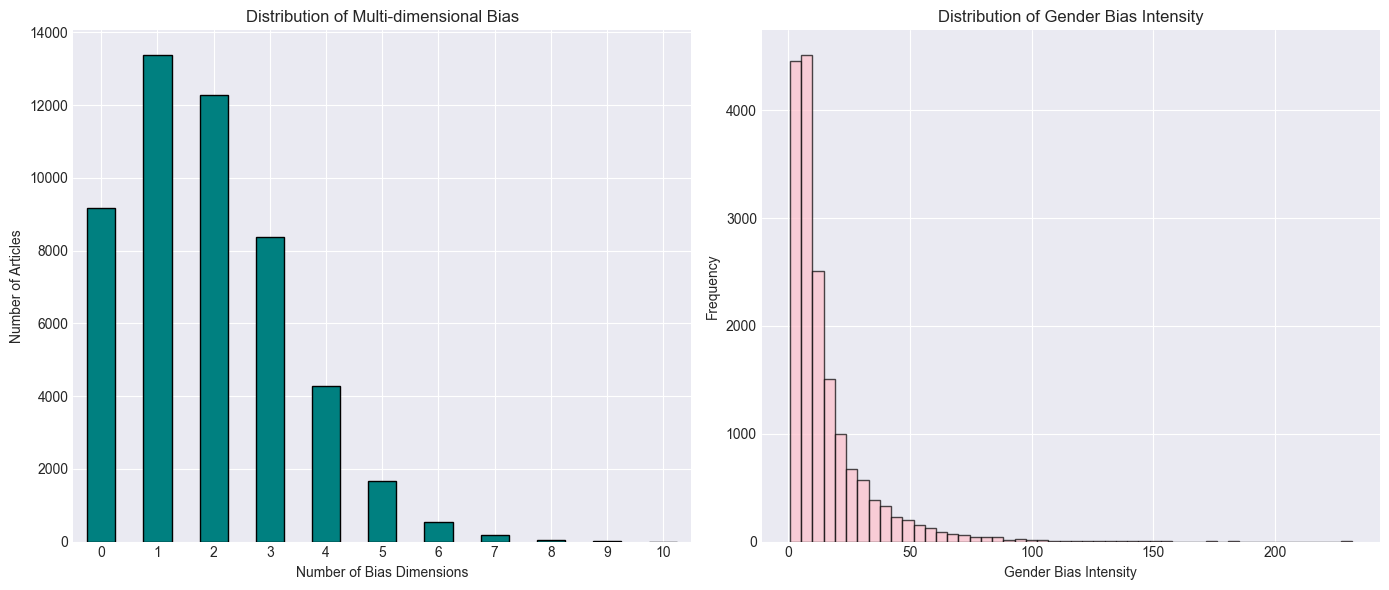

In [15]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution of bias dimensions per article
df['bias_dimension_count'].value_counts().sort_index().plot(kind='bar', ax=axes[0],
                                                            color='teal', edgecolor='black')
axes[0].set_xlabel('Number of Bias Dimensions')
axes[0].set_ylabel('Number of Articles')
axes[0].set_title('Distribution of Multi-dimensional Bias')
axes[0].tick_params(axis='x', rotation=0)

# Intensity distribution (example: gender)
df[df['gender_intensity'] > 0]['gender_intensity'].hist(bins=50, ax=axes[1],
                                                        color='pink', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Gender Bias Intensity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Gender Bias Intensity')

plt.tight_layout()
plt.show()

#### Key Insights: Multi‑dimensional & Gender Bias

1) Most articles have few bias dimensions, with the highest counts at 0–2 dimensions and rapidly decreasing frequencies beyond 3+, meaning strongly multi‑dimensional bias is relatively rare.

2) Gender bias intensity is highly skewed, with most articles showing low intensity scores and a long right tail of fewer articles exhibiting very strong gender bias.

 ## 9. Feature Summary

In [16]:
# List all keyword features created
keyword_feature_cols = []

# Dimension-level features
for dimension in dimensions:
    keyword_feature_cols.extend([
        f'{dimension}_keyword_count',
        f'{dimension}_intensity',
        f'has_{dimension}_bias',
        f'{dimension}_stereotype_density'
    ])

# Category-level features
for dimension, categories in BIAS_KEYWORDS.items():
    for category in categories.keys():
        col = f'{dimension}_{category}_count'
        if col in df.columns:
            keyword_feature_cols.append(col)

# Co-occurrence features
for dim1, dim2 in combinations(dimensions, 2):
    keyword_feature_cols.append(f'{dim1}_{dim2}_cooccurrence')

# Multi-dimensional
keyword_feature_cols.append('bias_dimension_count')

print(f"\n=== KEYWORD FEATURES SUMMARY ===")
print(f"Total keyword features: {len(keyword_feature_cols)}")
print(f"\nFeature breakdown:")
print(f"  - Dimension counts: {len(dimensions)}")
print(f"  - Intensity scores: {len(dimensions)}")
print(f"  - Bias flags: {len(dimensions)}")
print(f"  - Stereotype density: {len(dimensions)}")
print(f"  - Category counts: {len([c for c in keyword_feature_cols if '_count' in c]) - len(dimensions)}")
print(f"  - Co-occurrence: {len(list(combinations(dimensions, 2)))}")
print(f"  - Multi-dimensional: 1")


=== KEYWORD FEATURES SUMMARY ===
Total keyword features: 121

Feature breakdown:
  - Dimension counts: 10
  - Intensity scores: 10
  - Bias flags: 10
  - Stereotype density: 10
  - Category counts: 36
  - Co-occurrence: 45
  - Multi-dimensional: 1


 ## 10. Save Features

In [17]:
# Select columns to save
columns_to_save = ['url'] + keyword_feature_cols

df_keywords = df[columns_to_save].copy()

print(f"\nSaving keyword features...")
df_keywords.to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Rows: {len(df_keywords):,}")
print(f"  Features: {len(keyword_feature_cols)}")


Saving keyword features...
Saved to: ../data/processed/keyword_features.parquet
  Size: 3.84 MB
  Rows: 49,926
  Features: 121


 ## 11. Summary Report

BIAS DIMENSIONS COVERED:

1. Gender: 17,115 articles (34.3%)
2. Religion: 6,141 articles (12.3%)
3. Caste: 1,194 articles (2.4%)
4. Region: 14,133 articles (28.3%)
5. Socioeconomic: 5,156 articles (10.3%)
6. Political: 18,533 articles (37.1%)
7. Age: 16,971 articles (34.0%)
8. Disability: 1,336 articles (2.7%)
9. Urban_Rural: 10,192 articles (20.4%)
10. Language: 2,630 articles (5.3%)

FEATURE TYPES:

- Keyword counts (raw and per-category)
- Intensity scores (normalized by text length)
- Bias presence flags
- Stereotype density ratios
- Co-occurrence patterns
- Multi-dimensional bias indicators

KEY INSIGHTS:

- Articles with any bias: 40,747 (81.6%)
- Articles with multiple biases: 27,361 (54.8%)
- Average bias dimensions per article: 1.87